In [1]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
import glob

def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/imgs'
img_file_paths = glob.glob(work_dir+'/*.png')

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file_path in img_file_paths:
    print(detect_text(file_path))

-rw-rw-r-- 1 aiffel0042 aiffel0042 2346 10월  7 20:52 /home/aiffel0042/aiffel/ocr_python/my_google_api_key.json
Texts:

"LUSH
HABA
GOLD CLASS
obot
RIVERSIDE A
orb Cad
VINETA
WALK
CAFE&
BACKEREL
LA
"

"LUSH"

"HABA"

"GOLD"

"CLASS"

"obot"

"RIVERSIDE"

"A"

"orb"

"Cad"

"VINETA"

"WALK"

"CAFE&"

"BACKEREL"

"LA"
bounds: (682,87),(700,69),(710,80),(693,98)
None
Texts:

"Tesseract OCR
"

"Tesseract"

"OCR"
bounds: (372,184),(513,184),(513,239),(372,239)
None


In [2]:
import matplotlib.pyplot as plt
import keras_ocr
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0042/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel0042/.keras-ocr/crnn_kurapan.h5


In [3]:
images = [ keras_ocr.tools.read(file_path) for file_path in img_file_paths]
prediction_groups = [pipeline.recognize([file_path]) for file_path in img_file_paths]

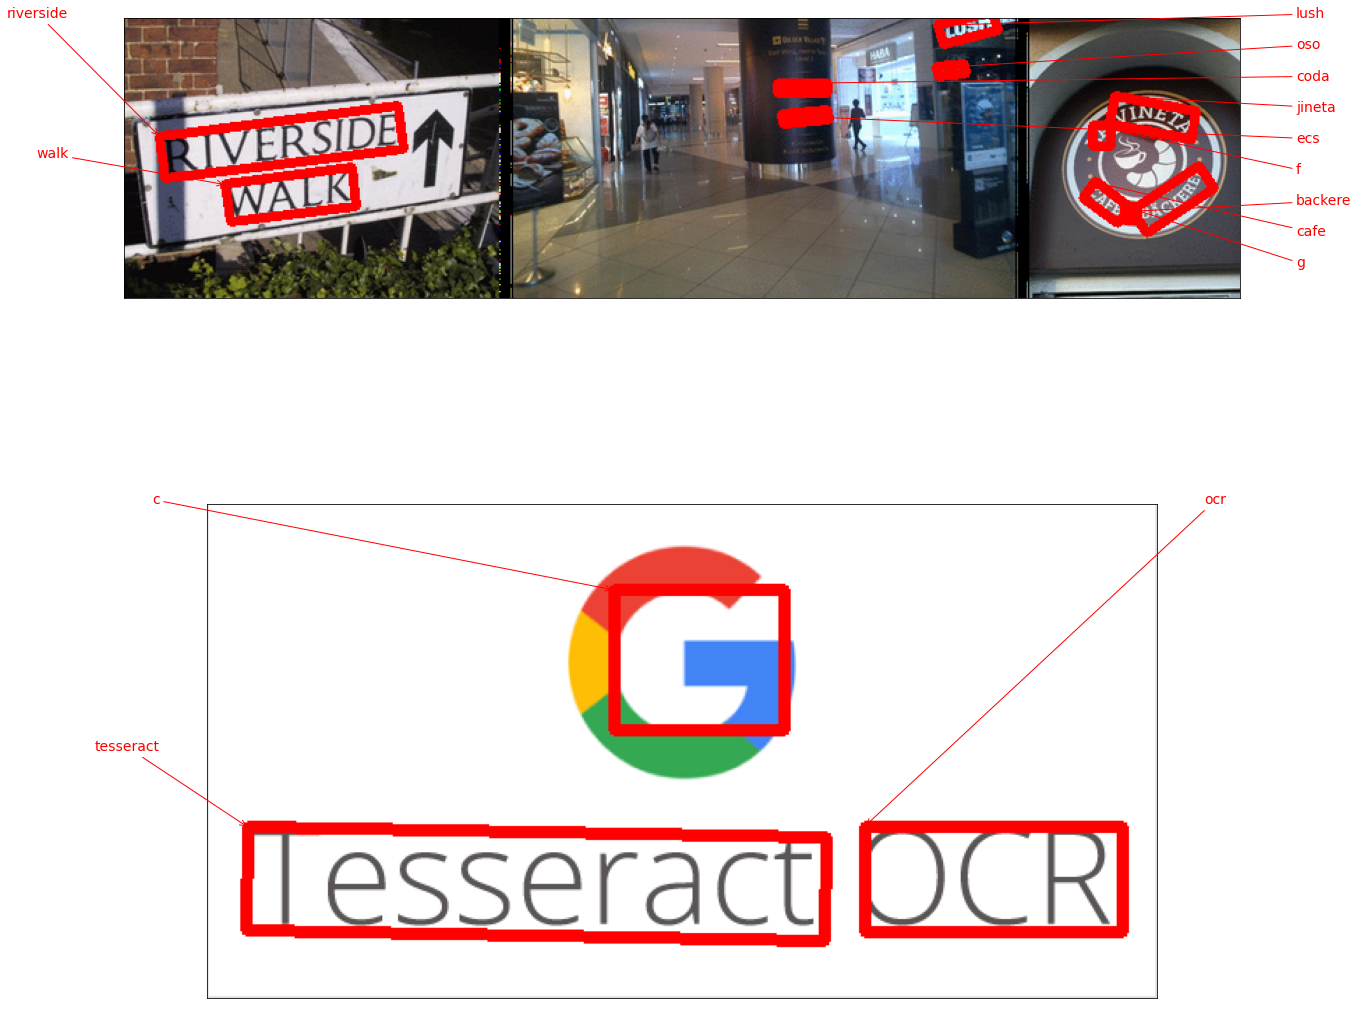

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)


In [5]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list





In [8]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
dst_dir = os.getenv('HOME')+'/aiffel/ocr_python'
for file_path in img_file_paths:
    print(file_path)
    cropped_image_path_list = crop_word_regions(file_path, dst_dir)
    recognize_images(cropped_image_path_list)

/home/aiffel0042/aiffel/ocr_python/imgs/img2.png
/home/aiffel0042/aiffel/ocr_python/0000.png
fot t } Bh é 5 ‘@ [Cc

Done
/home/aiffel0042/aiffel/ocr_python/imgs/my_image.png
/home/aiffel0042/aiffel/ocr_python/0000.png
/home/aiffel0042/aiffel/ocr_python/0001.png
/home/aiffel0042/aiffel/ocr_python/0002.png
J

Tesseract

()C R

Done


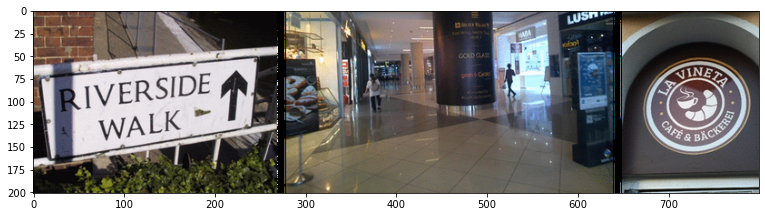

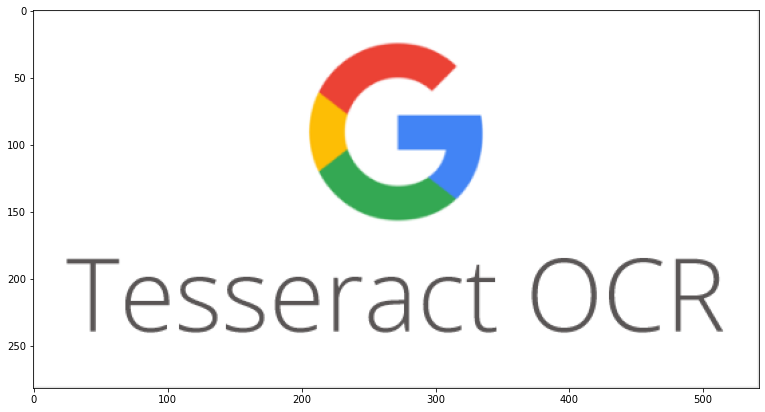

In [11]:
import cv2
import matplotlib.pyplot as plt

for path in img_file_paths:
    plt.figure(figsize=(13,13))
    plt.imshow(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB))
    plt.show()

#### image 번역기 서비스를 한다고 했을 때를 가정하자. 해당 서비스에서는 정확도와 처리속도를 중심으로 생각해야 한다.

#### Google OCR API는 첫 번째 사진중 가운데 그림 기둥내에 GOLD CLASS를 유일하게 감지하였다. Tesseract는 detection 부분에서 감지를 하지 못한 것으로 보인다. 또한 감지된 부분에서 O를 괄호로 인식하였다. 
#### 따라서, 정확도는 Google OCR API, keras-ocr, Tesseract 순서로 보인다.
#### 처리속도의 경우 keras-ocr은 너무 느리기 때문에 부적절해 보인다.
#### 2가지 기준하에 3개의 모델에서는 Google OCR API가 가장 적당하다고 생각한다.